# Configurações

In [1]:
# Imports
import numpy as np
from multiprocessing import cpu_count
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import copy

# Config
np.random.seed(0)
tf.random.set_seed(0)
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
nproc = cpu_count()

In [2]:
# Load data
mnist = tf.keras.datasets.mnist
# Train/test split
(x, y),(x_test, y_test) = mnist.load_data()
# Normalize values
x, x_test = x / 255.0, x_test / 255.0

In [3]:
# Shuffle and create val set
N = len(x)
new_order = np.random.permutation(N)
x = x[new_order,:]
y = y[new_order]
tr_pct = 0.8
div_idx = int(tr_pct*N)
x_train = x[:div_idx, :]
x_val = x[div_idx:, :]
y_train = y[:div_idx]
y_val = y[div_idx:]

# Modelo exemplo

In [4]:
# Baseline code (Prof. Von Zuben)
acc, loss = 0, 0
# Average 3 times for better results
for _ in range(3):
    model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(x, y, epochs=5, verbose=0)

    loss_, acc_ = model.evaluate(x_test, y_test)
    loss += loss_
    acc += acc_
print("Acc:", acc/3, "Loss:", loss/3)

313/313 [==============================] - 1s 2ms/step - loss: 0.0590 - accuracy: 0.9816
Acc: 0.9799666603406271 Loss: 0.06389309465885162


In [5]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


# Modelo concorrente

Para criar um modelo com desempenho superior, primeiramente foram testadas algumas configurações para um treinamento com o mesmo número de épocas (5) e um número igual ou menor de parâmtros. A maior diferença em relação ao modelo de baseline foi a adição de camadas de batch normalization (que pode aumentar a velocidade de convergência do treinamento) e o aumento do batch size (pois reduz significativamente o tempo de treinamento). Foram testadas algumas possibilidades de quantidade de camadas intermediárias, quantidade de neurônios nessas camadas, e porcentagem de dropout:

In [6]:
n_output_neurons = 10
epochs = 5
bs = 128
opt=tf.keras.optimizers.Adam()
fn=tf.keras.losses.SparseCategoricalCrossentropy()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
params = {
    'hidden_layers': [[256], [128, 128], [256, 256], [128, 128, 128], [256, 256, 256]],
    'dropout': [0, 0.3, 0.5]
}

In [7]:
def create_mlp(hidden_layers,
               n_output_neurons,
               p):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for layer in hidden_layers:
        model.add(tf.keras.layers.Dense(layer))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(tf.nn.relu))
        model.add(tf.keras.layers.Dropout(p))
    model.add(tf.keras.layers.Dense(n_output_neurons, tf.nn.softmax))
    return model

## Seleção de hiperparâmetros

In [8]:
# Hyperparameters search
best_loss = np.float('inf')
for layers in params['hidden_layers']:
    for p in params['dropout']:
        model = create_mlp(layers, n_output_neurons, p)
        model.compile(optimizer=opt,
                        loss=fn,
                        metrics='accuracy')
        history = model.fit(x_train, y_train, epochs=epochs, verbose=0,
                    callbacks=[callback,], workers=nproc, shuffle=True,
                    batch_size=bs)
        print("Arquitetura:", layers+[n_output_neurons],
                "Dropout:", p)
        loss, acc = model.evaluate(x_val, y_val,
                    batch_size=bs)
        if loss < best_loss:
            best_loss = loss
            best_layers = layers
            best_p = p
            best_history = history

Arquitetura: [256, 10] Dropout: 0
94/94 [==============================] - 0s 2ms/step - loss: 0.0915 - accuracy: 0.9720
Arquitetura: [256, 10] Dropout: 0.3
94/94 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9761
Arquitetura: [256, 10] Dropout: 0.5
94/94 [==============================] - 0s 3ms/step - loss: 0.0955 - accuracy: 0.9718
Arquitetura: [128, 128, 10] Dropout: 0
94/94 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.9742
Arquitetura: [128, 128, 10] Dropout: 0.3
94/94 [==============================] - 0s 2ms/step - loss: 0.0886 - accuracy: 0.9744
Arquitetura: [128, 128, 10] Dropout: 0.5
94/94 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.9661
Arquitetura: [256, 256, 10] Dropout: 0
94/94 [==============================] - 0s 3ms/step - loss: 0.0782 - accuracy: 0.9783
Arquitetura: [256, 256, 10] Dropout: 0.3
94/94 [==============================] - 0s 3ms/step - loss: 0.0748 - accuracy: 0.97

In [9]:
best_model = create_mlp(best_layers, n_output_neurons, best_p)
best_model.build(x.shape)
best_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (60000, 784)              0         
_________________________________________________________________
dense_54 (Dense)             (60000, 256)              200960    
_________________________________________________________________
batch_normalization_33 (Batc (60000, 256)              1024      
_________________________________________________________________
activation_33 (Activation)   (60000, 256)              0         
_________________________________________________________________
dropout_36 (Dropout)         (60000, 256)              0         
_________________________________________________________________
dense_55 (Dense)             (60000, 256)              65792     
_________________________________________________________________
batch_normalization_34 (Batc (60000, 256)            

## Treinamento

O modelo selecionado têm significativamente menos parâmetros (271370 comparado com 407050 do modelo exemplo), agora vamos treinar 5 épocas em todas as amostras de treino para comparar com o desempenho do modelo exemplo:

In [10]:
# Average 3 times for better results
acc, loss = 0, 0
for _ in range(3):
    model = create_mlp(best_layers, n_output_neurons, best_p)
    model.compile(optimizer=opt,loss=fn,metrics=['accuracy'])
    best_history = model.fit(x, y, epochs=epochs, verbose=0,
                callbacks=[callback,], batch_size=bs, workers=nproc, shuffle=True)

    loss_, acc_ = model.evaluate(x_test, y_test)
    loss += loss_
    acc += acc_
print("Acc:", acc/3, "Loss:", loss/3)

313/313 [==============================] - 0s 1ms/step - loss: 0.0618 - accuracy: 0.9803
Acc: 0.9810333450635275 Loss: 0.06064063558975855


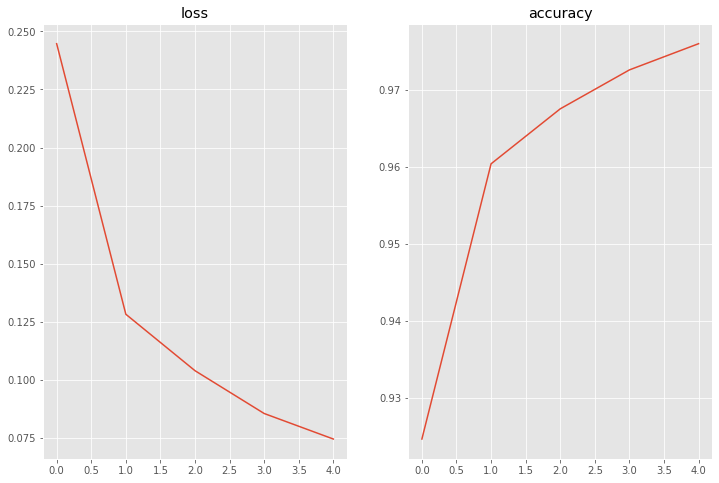

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
plt.plot(best_history.history['loss'])
plt.title('loss')
ax = fig.add_subplot(1,2,2)
plt.plot(best_history.history['accuracy'])
plt.title("accuracy")
plt.show()

A acurácia já é ligeiramente superior do que o modelo exemplo. Pela curva de aprendizado acima é possível perceber que o modelo tinha um movimento de crescimento de acurácia na quinta época, podemos testar o treinamento por mais épocas:

In [12]:
# Average 3 times for better results
acc, loss = 0, 0
for _ in range(3):
    model = create_mlp(best_layers, n_output_neurons, best_p)
    model.compile(optimizer=opt,loss=fn,metrics=['accuracy'])
    best_history = model.fit(x, y, epochs=20, verbose=0,
                callbacks=[callback,], batch_size=bs, workers=nproc, shuffle=True)

    loss_, acc_ = model.evaluate(x_test, y_test)
    loss += loss_
    acc += acc_
print("Acc:", acc/3, "Loss:", loss/3)

313/313 [==============================] - 0s 1ms/step - loss: 0.0583 - accuracy: 0.9830
Acc: 0.9828666647275289 Loss: 0.05823491637905439


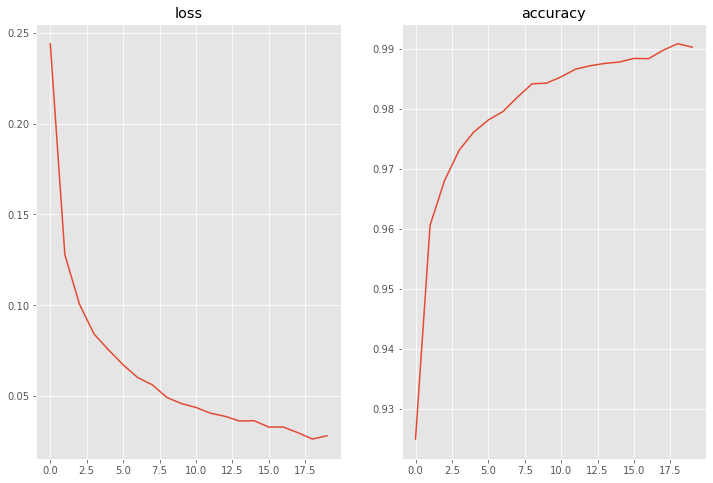

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
plt.plot(best_history.history['loss'])
plt.title('loss')
ax = fig.add_subplot(1,2,2)
plt.plot(best_history.history['accuracy'])
plt.title("accuracy")
plt.show()

# Resultados

O modelo final possui menos parâmetros, uma perda (entropia cruzada) inferior e uma acurácia superior, em relação ao modelo exemplo.

Modelo | Camadas | Dropout | Outro |  N. Parâmetros | Épocas | Entropia Cruzada | Acurácia
--- | --- | --- | --- | --- | --- | --- | ---
1 | 512-10 | 0.5 | - | 407,050  | 5 | 0.0638 | 0.9800
2 | 256-256-10 | 0.3 | BatchNorm | 271,370 | 5 | 0.0606 | 0.9810
3 | 256-256-10 | 0.3 | BatchNorm | 271,370 | 20 | **0.0582** | **0.9829**